# Stochastic Processes
### Understanding Uncertainty

## Introduction

- A **stochastic process** is a random phenomenon that changes over time
- We're going to look at the workhorse model of stochastic processes: The Markov chain
- Like most concepts we're looking at, you can spend your adult life studying these concepts, so we focus on the kernel of the idea in its most commonly used form
- Because these data are typically not structured, tabular data, they can be a little more demanding to work with (closer to natural language processing than regression analysis)
- Markov chains were invented by Markov when he studied how words/letters transition from one to the next

1. Sequences and the State Space
2. The Transition Matrix
3. Forecasting and Steady State Distribution

# 1. Sequences and the State Space

## Sequences
- A **sequence** is a collection of values drawn from a particular set, ordered by a "time" index
    - A classic example of a sequence in mathematics is a sequence of real numbers: $x_n = \frac{1}{n}$ with $n$ taking positive integer values, like $1, 1/2, 1/3, 1/4, 1/5, ...$
    - Stock prices are sequences of numbers indexed by time: What's the price of a share of Apple at this moment?
    - Electroencephalogram (EEG) tracks electrical activity in the brain, electrocardiogram (EKG) tracks electrical activity in the heart
    - Music is "sound in time": Chord progressions and melodies are sequences of notes
    - Text is a sequence of word **tokens** and $n$-grams of tokens, arranged to create meaning
- A **stochastic process** is a sequence $\{ X_t \}_{t=1}^T$ whose values are random: Given our information, we cannot perfectly predict what will happen next
- We want to model stochastic sequences and model how they evolve over time
    - Our non-parametric models foreshadow powerful tools in machine learning: Attention, Transformers, Recurrent Neural Networks, Hidden Markov Chains

## The State Space
- The core concept for stochastic sequences is the **state space**: What are the values the sequence can take?
    - For stock prices, they're positive numbers denominated in dollars
    - For precision health, it's the recent measurements of the patient's vital signs
    - For music, they're chords in a key (e.g. I, IV, vi, V or ii, V7, I)
    - For text, it's a chunk of words (e.g. "To be or not...")
- The state space represents all of the possible, relevant configurations of the system
- Enumerating it may be impractical, which is why we use theory and data and models to gain traction (many of the advances that made LLMs possible concern the best way to enumerate and model the state space of a sequence)

## Example 1: The Yellowfin Tuna Genome
- The DNA of an organism is a sequence of letters, $\{G, C, A, T\}$, that represent the nucleotides Guanine, Cytosine, Adenine and Thymine
- As we work along the DNA of an organism, we go back and forth between G, C, A, and T: There is a sequence of transitions, and they're not uniformly at random
- How might we model this?
- The simplest **state space** for this problem is just $\{G, C, A, T\}$


In [1]:
import re
import numpy as np
import pandas as pd

with open('./tuna.csv', 'r') as f: # Open the tuna file
    seq = [] # Save states here
    for i, line in enumerate(f): # For each line,
        line = re.sub(r'\n', '', line) # remove newline characters
        line = line.lower() # Convert to lowercase
        line = re.sub(r'[^gcat]', '', line, flags=re.IGNORECASE) # Thermonucelar clean
        seq.extend(line) # Add new nucleotides ot the end of the sequence
seq = np.array(seq) # Convert to numpy array for computational convenience
print(seq[:50])

['t' 't' 't' 't' 't' 'g' 'g' 'g' 'c' 'c' 'c' 'a' 'a' 'a' 'c' 't' 'a' 'g'
 't' 'g' 'g' 'c' 't' 't' 't' 't' 'c' 'a' 't' 'c' 'a' 'g' 'a' 'a' 'c' 'c'
 'g' 'a' 't' 'g' 'c' 'a' 'g' 'a' 'c' 't' 'c' 'a' 'c' 'c']


In [2]:
states = list(np.unique(seq)) # Get unique elements and convert to list
print('States:\n', states)

States:
 ['a', 'c', 'g', 't']


## Exercise 1:
- For the taxicab trajectory data, determine your state space and clean your sequences of cab rides

## Example 2: Bach Chorales
- Music is "sound in time"
- Music can sound "challenging" or "complex" or "intellectually demanding" (e.g. Arnold Schoenberg, Pierre Boulez, Edgard Varese)
- Music can challenge assumptions (e.g. John Cage)
- Music can be simple and yet still evoke complex responses (e.g. Philip Glass)
- Bach, though, is pretty close to the platonic distillation of western harmony 


## The State Space: Chords
- Harmony is the "deliberate combination of tones/notes played simultaneously"
- In western music, there are 12 notes: C, C#/Db, D, D#/Eb, E, F, F#/Gb, G, G#/Ab, A, A#/Bb, B. The notes without #/b are the "white" keys on the piano, and those with the #/b are the "black" keys.
- Picking any set of notes yields a **chord**: A combination of tones/notes played at the same time
- Most chords sound "bad" (dissonant), and a culture's conception of what sounds good or bad changes over time
- Our data are clean enough that you don't need to understand music theory, just that the data are a sequence of chords having some common structure (typically three to four notes, spaced by third: C major = CEG, A minor = ACE, G7 or G dominant 7 = GBDF, F suspended 4 = FBbC)
- The set of chords will be token from which we build a state space

![Notes](./src/piano-keys-chart.jpg)

# 2. The Transition Matrix

## Moving from State to State
- Now we have a sequence and a state space: The sequence **transitions** unpredictably from one state to another
- But the current state often reveals information about what the next state is likely to be: G doesn't transition uniformly at random to A, the A minor chord rarely transitions to Bb major, etc.

- ## Transition Proportions
- To model this dependence in a data-driven way, we can think about conditional proportions
$$
\widehat{pr}[X_t=z'|X_{t-1}=z] = \dfrac{ \frac{1}{T} \sum_{s=1}^T \mathbb{I} \{ X_s=z', X_{s-1}=z \}}{ \frac{1}{T} \sum_{s=1}^T \mathbb{I} \{ X_{s-1}=z \}}
$$
where $T$ is the total number of terms of the sequence. So, the co-occurences of transition from $z_{t-1}$ to $z_t$, divided by the total number of occurences of $z_{t-1}$

- These proportions represent the fraction of the time we move from one state to the other
- We can tabulate them in a matrix, were the rows correspond to the current state and the columns to the next state, and the $(z,z')$ value corresponds to the transition proportion from $z$ to $z'$

- This is just a contingency table, where the rows and columns correspond to "current state" and "next state", respectively

In [3]:
## Create a S X S transition matrix, and find the transition counts:
S = len(states)
T = len(seq)
tr_counts = np.zeros( (S, S) )

for t in range(1,T): # For each transition
    # Current and next tokens:
    x_tm1 = seq[t-1] # previous state
    x_t = seq[t] # current state
    # Determine transition indices:
    index_from = states.index(x_tm1)
    index_to = states.index(x_t)
    # Update transition counts:
    tr_counts[index_to, index_from] += 1

print(f'\nTransition Counts:\n {tr_counts}')

# Sum the transition counts by row:
row_sums = tr_counts.sum(axis=1, keepdims=True)
print(f'\nState Counts: \n {row_sums}')

# Sum the transition counts by row:
row_sums = tr_counts.sum(axis=1, keepdims=True)
print(f'\nState proportions: \n {row_sums/np.sum(row_sums)}')

# Normalize the transition count matrix to get proportions:
tr_pr = np.divide(tr_counts, row_sums, 
                            out=np.zeros_like(tr_counts), 
                            where=row_sums!=0)

print(f'\nTransition Proportions:')
pd.DataFrame(np.round(tr_pr,2), index=states, columns=states)


Transition Counts:
 [[69820. 67071. 41986. 45712.]
 [45094. 34456. 42538. 48819.]
 [48200. 21519. 38643. 63309.]
 [61475. 47860. 48504. 77355.]]

State Counts: 
 [[224589.]
 [170907.]
 [171671.]
 [235194.]]

State proportions: 
 [[0.27991017]
 [0.21300512]
 [0.21395731]
 [0.29312741]]

Transition Proportions:


,a,c,g,t
a,0.31,0.30,0.19,0.20
c,0.26,0.20,0.25,0.29
g,0.28,0.13,0.23,0.37
t,0.26,0.20,0.21,0.33


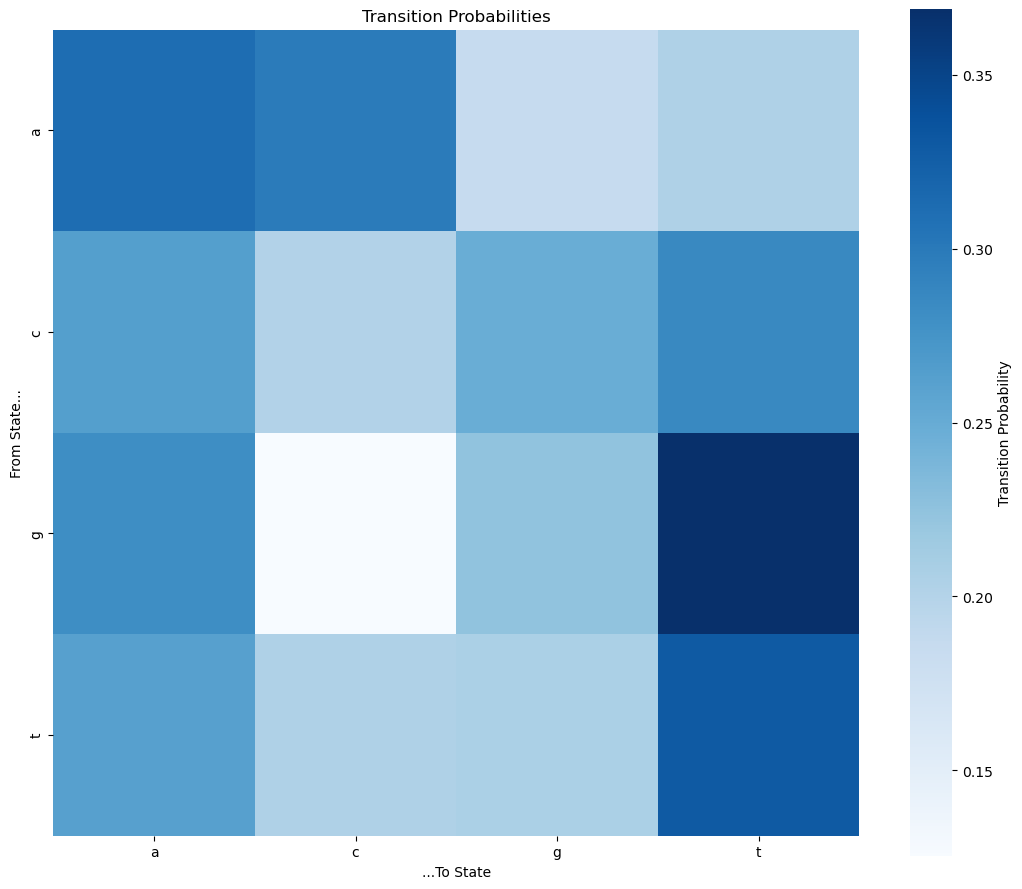

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 11))
sns.heatmap(tr_pr, 
            cmap='Blues',
            square=True,          
            xticklabels=states,
            yticklabels=states,
            cbar_kws={'label': 'Transition Probability'})

plt.title('Transition Probabilities')
plt.xlabel('...To State')
plt.ylabel('From State...')
plt.show()

## Exercise 2:
- Compute the transition matrix for the taxicab data between neighborhoods in Manhattan
- Plot it in a heat map. What are the most common routes?

## Bach
- Let's look at Bach as a noise machine

## Longer Sequential Dependence (Order)
- The **order** of the chain is how many tokens are used to comprise a state
- For example, you could use a state space of {aa, ac, ag, at, ca , cc, cg, ct, ...} instead of just {a,c,g,t}
- Increasing the order of the chain includes more memory of recent tokens in the definition of a state, an typically produces more realistic results (as long as the true behavior has higher dependence on past values of the state)
- Computational biologists tell me that order 3 is where structures start to emerge, so let's use that

In [5]:
order = 3
sq = [''.join(seq[(t-order-1):(t-1)]) for t in range(order+1, T)]

states = list(np.unique(sq))
print('States: \n', states)
S = len(states)
T = len(sq)

tr_counts = np.zeros( (S, S) )
for t in range(1,T):
    x_previous = sq[t-1] # previous state
    x_next = sq[t] # current token

    index_from = states.index(x_previous)
    index_to = states.index(x_next)

    tr_counts[index_to, index_from] += 1

print(f'Transition Counts:\n {tr_counts}')

States: 
 ['aaa', 'aac', 'aag', 'aat', 'aca', 'acc', 'acg', 'act', 'aga', 'agc', 'agg', 'agt', 'ata', 'atc', 'atg', 'att', 'caa', 'cac', 'cag', 'cat', 'cca', 'ccc', 'ccg', 'cct', 'cga', 'cgc', 'cgg', 'cgt', 'cta', 'ctc', 'ctg', 'ctt', 'gaa', 'gac', 'gag', 'gat', 'gca', 'gcc', 'gcg', 'gct', 'gga', 'ggc', 'ggg', 'ggt', 'gta', 'gtc', 'gtg', 'gtt', 'taa', 'tac', 'tag', 'tat', 'tca', 'tcc', 'tcg', 'tct', 'tga', 'tgc', 'tgg', 'tgt', 'tta', 'ttc', 'ttg', 'ttt']
Transition Counts:
 [[ 9182.     0.     0. ...     0.     0.     0.]
 [ 4902.     0.     0. ...     0.     0.     0.]
 [ 5578.     0.     0. ...     0.     0.     0.]
 ...
 [    0.     0.     0. ...     0.     0.  9654.]
 [    0.     0.     0. ...     0.     0.  5858.]
 [    0.     0.     0. ...     0.     0. 11232.]]


In [6]:
#col_sums = tr_counts.sum(axis=0, keepdims=True)
col_sums = tr_counts.sum(axis=0)
print('State proportions: \n')

tr_df = pd.DataFrame(col_sums/np.sum(col_sums,axis=1), index=states)
print(tr_df)

State proportions: 



AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
tr_pr = np.divide(tr_counts, col_sums, 
                             out=np.zeros_like(tr_counts), 
                             where=col_sums!=0)

print('Transition Proportions:\n')

tr_df = pd.DataFrame(np.round(tr_pr,2), index=states, columns=states)
print(tr_df)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(tr_pr, 
            cmap='Blues',       # Or 'Blues', 'plasma', whatever looks good
            square=True,          # Keep cells square
            xticklabels=states,
            yticklabels=states,
            cbar_kws={'label': 'Transition Probability'})

plt.title('Transition Probabilities')
plt.xlabel('...To State')
plt.ylabel('From State...')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Sparse versus Dense
- If a transition matrix has a significant number of zeros, it eventually becomes easier to track the non-zero entries alone
- If that's the case, we call the matrix **sparse**: There are special methods for storing and computing sparse matrices than as $N \times N$ arrays
- On a computer with a very large state space and high dependence (e.g. text analytics), transition matrices are inherently sparse -- you can imagine a lot of LLM techniques as being ways to track meaning (high order dependence) in sparse contexts across n-grams of tokens

## Connected Chain
- A Markov chain is **connected** if for every pair of states $a$ and $b$, there is a sequence of transitions from $a$ to $b$ that has non-zero probability
- Examples:
    - Any "short" length of nucleotides will eventually appear in a genome
    - Unless you're playing something avant garde, it is **not** the case that you will see "every" chord in a single piece (i.e. concept of a key signature)
- Disconnected chains typically have two or more possible sets of states that eventually communicate within, but not across
- We can use some code from the `networkx` package for analyzing graphs, and the transition proportion matrix to see if the chain is connected

In [ ]:
import networkx as nx
import numpy as np

G = nx.from_numpy_array(tr_pr, create_using=nx.DiGraph()) # Create directed graph in nx
is_connected = nx.is_strongly_connected(G) # Test connectivity
print(f"Connected: {is_connected}")

# Get connected components if not connected
if not is_connected:
    strong_components = list(nx.strongly_connected_components(G))
    print(f"Number of strongly connected components: {len(strong_components)}")

## Exercise 3:
- Explain why taxicabs are most likely order 1, and not 2 or more.
- Are taxicab trajectories probably connected or not?

## Example: Bach
- This is where rules of harmony come from

# 3. Forecasting and Simulation

## Simulation/Generation
- Each row of our matrix gives the conditional empirical probability of the next state, conditional on the current state
- If we pick the next state at random according to those probabilities, we get a new state; repeating this process is called **simulation**
- The more recent term for this is **generative modeling**

In [ ]:
np.random.seed(100)

initial_state = np.random.choice(states) # Choose an initial state at random
state_index = states.index(initial_state) # Get the index of the initial state
print(f'Initial state: {initial_state}') 

n_sim = 20

simulation = [initial_state]
for t in range(n_sim-1): 
    pr_t = tr_pr[:,state_index] # Transition probabilities at this state
    state_index = np.random.choice(len(states), p=pr_t) # Choose new state index
    simulation.append(states[state_index]) # Append new state to simulation

print(simulation)


## Forecasting
- If we don't pick a new state but instead multiply a vector with a one at the current state and zeroes elsewhere, we get a guess of the distribution of the next state; repeating this process is called **forecasting**
- What happens over time to the specificity of the forecast?

In [ ]:
np.random.seed(100)

initial_state = np.random.choice(states) # Choose an initial state at random
state_index = states.index(initial_state) # Get the index of the initial state

##Initial density:
density = np.zeros(len(states))
density[state_index] = 1

sns.barplot(x=states,y=density).set(title=f'Forecast: 0')
plt.xticks(rotation=90)
plt.show()

n_sim = 5

forecast = [initial_state]
for t in range(n_sim): 
    density = tr_pr @ density
    forecast.append(density) # Append new forecast
    sns.barplot(x=states,y=density).set(title=f'Forecast, period: {str(t+1)}')
    plt.xticks(rotation=90)
    plt.show()


- For awhile, knowing the initial state (aga) is helpful for forecasting the likelihood of the next state
- By period 5, though, things are relatively noisy, and the process could be anywhere

## Forecasting
- How does this calculation work?
- If the transition matrix is $T$, we can model the initial density over states as a vector $\pi_0$ with zeros everywhere except the index $k$ for the current state (the vector is 0 except for the index that corresponds to 'aga')
- Then we multiply 
$$
T \pi_0 = \left[ \begin{array} {cccc} p_{00} & p_{01} & \dots & p_{0S} \\
p_{11} & p_{12} & \dots & p_{1S} \\
p_{21} & p_{22} & \dots & p_{2S} \\
\vdots & \vdots & \ddots & \vdots \\
p_{S1} & p_{S2} & \dots & p_{SS} \\
\end{array}\right] \left( \begin{array} {c} 0 \\ \vdots \\ 1 \\ \vdots \\ 0 \end{array}\right) = \left( \begin{array} {c} p_{k1} \\ \vdots \\ p_{ks} \\ \vdots \\ p_{kS} \end{array}\right)= \pi_1
$$
- This is just the conditional proportions for $k$ transitioning to each of the states; that's the first figure above with four values
- When we multiply a second time, we get $T^2 \pi_0 = T \pi_1 = \pi_2$, and we see how that density transitions to the second picture with 16 values. The values of $\pi_2$ all look like $\sum_{s=1}^S p_{ss'} p_{ks}$: The sum of all the conditional proportions of paths from $k$ to $s'$
- We can use matrix multiplication to iterate this process, generating predictions of where the chain will be as time ticks forward
- Eventually, however, our predictions will typically become uninformative: As time goes by, the chain wanders, and it visits many states, and probabilities across future paths become relatively stable and uninformative

## Exercise 4:
- Simulate taxicab trajectories in Manhattan, starting from an arbitrary initial condition
- For each neighborhood, create a sequence of forecasts of where the cab is likely to be in 2, 3, 5, and 10 trips.

## Conclusion
- Markov chains are our workhorse tool for modeling dynamic phenomena: They're flexible, easy to compute, and provide insights into how current states predict future ones
- They are the foundation of text analytics

## Exercise 5:
- Create a Markov Chain class that takes a list of sequences, determines the state space, computes the transition proportions, and can simulate new observations